In [1]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from python_speech_features import mfcc

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, BatchNormalization, MaxPool2D,
                                     GlobalAveragePooling2D, Dense, Dropout, Flatten)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

# fijamos semilla
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
class Config:
    def __init__(self, mode='conv', nfilt=26, nfeat=13, nfft=4096, rate=16000):
        self.mode = mode
        self.nfilt = nfilt
        self.nfeat = nfeat
        self.nfft = nfft
        self.rate = rate
        self.step = int(rate/10)

config = Config(mode='conv')

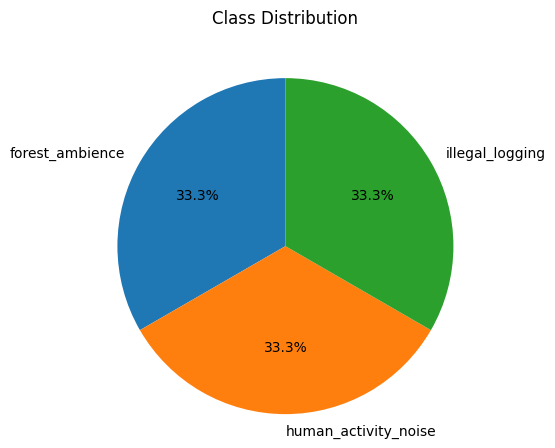

In [ ]:
# Lee el dataset
df = pd.read_csv('dataset_balanceado_3.csv')
df.set_index('filename', inplace=True)

base_path = 'Audios_ESC4_v2_16k/'  # carpeta raíz

# Calcular longitud de cada audio
for f, row in df.iterrows():
    file_path = os.path.join(base_path, row['label'], f)
    
    if os.path.exists(file_path):
        rate, signal = wavfile.read(file_path)
        df.at[f, 'length'] = signal.shape[0] / rate
    else:
        print(f"⚠️ Archivo no encontrado: {file_path}")

# Distribución de clases
classes = list(np.unique(df.label))
class_dist = df.groupby('label')['length'].mean()

# Sampling aleatorio
n_samples = 2 * int(df['length'].sum() / 0.1)
prob_dist = class_dist / class_dist.sum()
choices = np.random.choice(class_dist.index, p=prob_dist)

# Gráfico
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

In [5]:
import math

def build_rand_feat():
    X_list = []
    y_list = []

    # Parámetros MFCC (python_speech_features por defecto)
    winlen = 0.025
    winstep = 0.01
    numcep = config.nfeat

    # calcular número esperado de frames por cada sample (segundos = step / rate)
    step_seconds = config.step / config.rate
    expected_frames = int(math.floor((step_seconds - winlen) / winstep) + 1) if step_seconds > winlen else 1
    # podemos usar expected_frames como tamaño fijo; si quieres otro valor, cambia aquí
    target_frames = expected_frames

    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index, p = prob_dist)
        file = np.random.choice(df[df.label==rand_class].index)
        file_path = os.path.join('Audios_ESC4_v2_16k', df.at[file, 'label'], file)
        rate, wav = wavfile.read(file_path)

        # stereo -> mono
        if wav.ndim == 2:
            wav = wav.mean(axis=1)
        # asegurar float32 y escala relativa (opcional)
        wav = wav.astype(np.float32)
        # normalizar amplitud si están en int16 por ejemplo (opcional)
        # if wav.dtype == np.int16:
        #     wav = wav / 32768.0

        label = df.at[file, 'label']

        # cortar/pad para tener exactamente config.step muestras (ya lo hacías)
        if wav.shape[0] < config.step:
            pad_width = config.step - wav.shape[0]
            wav = np.pad(wav, (0, pad_width), mode='constant')
        if wav.shape[0] == config.step:
            sample = wav
        else:
            start = np.random.randint(0, wav.shape[0] - config.step)
            sample = wav[start:start + config.step]

        # MFCC: devuelve (n_frames, numcep) -> transponemos a (numcep, frames)
        mfcc_feat = mfcc(sample, rate, numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft).T
        # mfcc_feat.shape == (numcep, n_frames_variable)

        # --- Asegurar forma homogénea: padding o truncado en axis temporal (axis=1)
        if mfcc_feat.shape[1] < target_frames:
            pad_w = target_frames - mfcc_feat.shape[1]
            mfcc_feat = np.pad(mfcc_feat, ((0,0),(0,pad_w)), mode='constant')
        elif mfcc_feat.shape[1] > target_frames:
            mfcc_feat = mfcc_feat[:, :target_frames]

        # Dependiendo del modo, guardamos de forma consistente
        if config.mode == 'conv':
            # Guardamos (numcep, frames) -> luego reshape a (numcep, frames, 1)
            X_list.append(mfcc_feat)
        elif config.mode == 'time':
            # LSTM/TimeDistributed espera (frames, numcep)
            X_list.append(mfcc_feat.T)
        elif config.mode == 'vector':
            # vector fijo: promedio sobre frames -> shape (numcep,)
            X_list.append(np.mean(mfcc_feat, axis=1))
        else:
            raise ValueError("config.mode debe ser 'conv', 'time' o 'vector'")

        y_list.append(classes.index(label))

    # Convertir a numpy (ahora todas las entradas son homogéneas)
    X = np.array(X_list, dtype=np.float32)
    y = np.array(y_list, dtype=np.int32)

    # Normalización global (evita usar _min/_max mal calculados)
    X_min = X.min()
    X_max = X.max()
    X = (X - X_min) / (X_max - X_min + 1e-9)

    # Ajustar shapes para keras
    if config.mode == 'conv':
        # X tiene shape (N, numcep, frames) -> queremos (N, numcep, frames, 1)
        X = X.reshape((X.shape[0], X.shape[1], X.shape[2], 1))
    elif config.mode == 'time':
        # X está (N, frames, numcep) -> OK para LSTM/TimeDistributed
        pass
    elif config.mode == 'vector':
        # X está (N, numcep) -> OK para Dense
        pass

    y = to_categorical(y, num_classes=len(classes))
    return X, y, X_min, X_max, target_frames

X, y, X_min, X_max, target_frames = build_rand_feat()

100%|██████████| 130500/130500 [06:08<00:00, 353.73it/s]


In [6]:
# Guardar todo en un archivo comprimido
np.savez_compressed(
    "features_dataset_2.npz",
    X=X,
    y=y,
    X_min=X_min,
    X_max=X_max,
    target_frames=target_frames
)

print("✅ Features guardadas en features_dataset.npz")


✅ Features guardadas en features_dataset.npz


In [38]:
# Cargar el archivo
data = np.load("features_dataset.npz", allow_pickle=True)

# Recuperar variables
X = data["X"]
y = data["y"]
X_min = data["X_min"].item()
X_max = data["X_max"].item()
target_frames = data["target_frames"].item()

print("✅ Features cargadas. Shape X:", X.shape, "Shape y:", y.shape)


✅ Features cargadas. Shape X: (353338, 13, 8, 1) Shape y: (353338, 4)


In [7]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=45)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.2, random_state=42)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (83520, 13, 8, 1) (83520, 3)
Val: (20880, 13, 8, 1) (20880, 3)
Test: (26100, 13, 8, 1) (26100, 3)


In [8]:
y_flat = np.argmax(y, axis=1)
# class weights SOLO con y en enteros
class_weight_vals = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_flat),
    y=y_flat
)
class_weight = dict(zip(np.unique(y_flat), class_weight_vals))

In [10]:
from tensorflow.keras import layers, models
def get_tiny_cnn(input_shape, num_classes=3):
    inputs = layers.Input(shape=input_shape)

    # Bloque 1: pocos filtros
    x = layers.Conv2D(8, (3,3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    # Bloque 2
    x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    # Bloque 3
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)  # mucho más liviano que Flatten

    # Capa densa pequeña
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 13, 8, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 8, 8)       │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 13, 8, 8)       │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 4, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 4, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 6, 4, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 2, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 2, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 3, 2, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,267 (28.39 KB)

 Trainable params: 7,155 (27.95 KB)

 Non-trainable params: 112 (448.00 B)

Epoch 1/50
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7310 - loss: 0.6325 - val_accuracy: 0.7217 - val_loss: 0.6315 - learning_rate: 0.0010
Epoch 2/50
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7887 - loss: 0.5079 - val_accuracy: 0.7604 - val_loss: 0.5553 - learning_rate: 0.0010
Epoch 3/50
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8133 - loss: 0.4553 - val_accuracy: 0.6968 - val_loss: 0.6899 - learning_rate: 0.0010
Epoch 4/50
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8240 - loss: 0.4271 - val_accuracy: 0.7788 - val_loss: 0.5486 - learning_rate: 0.0010
Epoch 5/50
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8339 - loss: 0.4058 - val_accuracy: 0.6793 - val_loss: 0.7865 - learning_rate: 0.0010
Epoch 6/50
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8397 - loss: 0.3907 - val_accuracy: 0.7695 - val_loss: 0.5424 - learning_rate: 0.0010
Epoch 7/50
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8459 - 

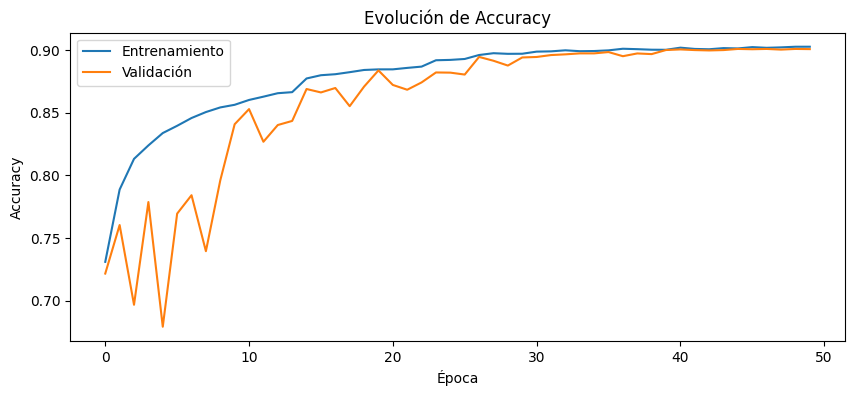

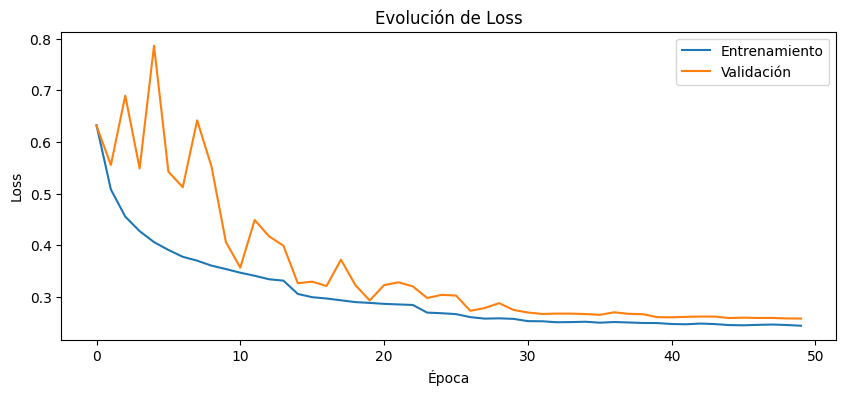

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Crear el modelo
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = get_tiny_cnn(input_shape=input_shape, num_classes=3)
model.summary()

# Callbacks para controlar entrenamiento
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

# Entrenar
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    class_weight=class_weight,
    verbose=1
)

# --- Graficar métricas ---
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Evolución de Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Evolución de Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()


816/816 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9010 - loss: 0.2625
Test Accuracy: 0.9010, Test Loss: 0.2625
816/816 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Classification Report:

                      precision    recall  f1-score   support

     forest_ambience     0.8907    0.8492    0.8694      8711
human_activity_noise     0.8784    0.9034    0.8907      8676
     illegal_logging     0.9333    0.9503    0.9417      8713

            accuracy                         0.9010     26100
           macro avg     0.9008    0.9010    0.9006     26100
        weighted avg     0.9008    0.9010    0.9006     26100



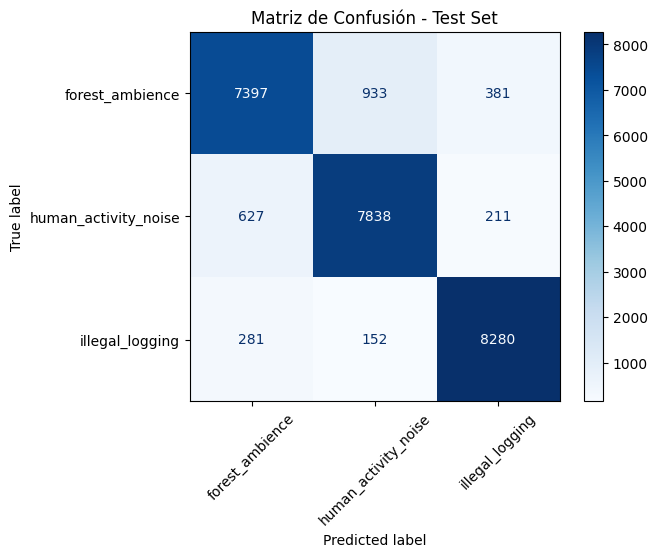

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Evaluar en el set de prueba
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# Predicciones
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Reporte detallado
target_names = classes

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=target_names, digits=4))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Matriz de Confusión - Test Set")
plt.show()


In [35]:
from scipy.signal import resample_poly
import numpy as np

def predict_audio_file(file_path, model, config, classes, X_min, X_max, target_frames,
                       window_stride=None, top_k=3, verbose=False):

    # 1) Cargar
    rate, wav = wavfile.read(file_path)

    # 2) mono y float32
    if wav.ndim == 2:
        wav = wav.mean(axis=1)
    wav = wav.astype(np.float32)

    # 4) ventana y stride
    if window_stride is None:
        window_stride = config.step // 2  # 50% overlap (puedes cambiar)

    preds_list = []

    # si el audio es más corto que config.step, hacemos un único padding
    if wav.shape[0] <= config.step:
        seg = np.pad(wav, (0, config.step - wav.shape[0]), mode='constant')
        starts = [0]
    else:
        starts = list(range(0, wav.shape[0] - config.step + 1, window_stride))
        # incluir última ventana para cubrir cola
        if (wav.shape[0] - config.step) % window_stride != 0:
            starts.append(wav.shape[0] - config.step)

    for s in starts:
        seg = wav[s:s + config.step]
        if seg.shape[0] < config.step:
            seg = np.pad(seg, (0, config.step - seg.shape[0]), mode='constant')

        # extraer MFCC (misma llamada que en build_rand_feat)
        mfcc_feat = mfcc(seg, rate, numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft).T

        # padding/truncado temporal a target_frames (mismo comportamiento que en build_rand_feat)
        if mfcc_feat.shape[1] < target_frames:
            pad_w = target_frames - mfcc_feat.shape[1]
            mfcc_feat = np.pad(mfcc_feat, ((0,0),(0,pad_w)), mode='constant')
        elif mfcc_feat.shape[1] > target_frames:
            mfcc_feat = mfcc_feat[:, :target_frames]

        # Normalizar usando X_min/X_max del entrenamiento (scalar)
        mfcc_norm = (mfcc_feat - X_min) / (X_max - X_min + 1e-9)

        # Preparar input según modo
        if config.mode == 'conv':
            x_in = mfcc_norm.reshape(1, mfcc_norm.shape[0], mfcc_norm.shape[1], 1)
        elif config.mode == 'time':
            x_in = mfcc_norm.T.reshape(1, mfcc_norm.shape[1], mfcc_norm.shape[0])
        elif config.mode == 'vector':
            x_in = np.mean(mfcc_norm, axis=1).reshape(1, -1)
        else:
            raise ValueError("config.mode debe ser 'conv','time' o 'vector'")

        # Predecir y guardar softmax vector
        prob = model.predict(x_in, verbose=0)[0]
        preds_list.append(prob)

    # Promediar probabilidades (soft-voting)
    preds_arr = np.array(preds_list)
    avg_prob = preds_arr.mean(axis=0)

    # Top-k
    top_idx = avg_prob.argsort()[-top_k:][::-1]
    top_results = [(classes[i], float(avg_prob[i])) for i in top_idx]


    # info adicional
    if verbose:
        print(f"Num ventanas: {len(preds_list)}, stride (samples): {window_stride}")
        for cls, p in top_results:
            print(f"{cls}: {p:.4f}")

    return top_results, avg_prob

# Ejemplo de uso:
# Asegúrate de usar 'classes' en el mismo orden que el used para to_categorical (p. ej. classes = list(np.unique(df.label)))
# X_min, X_max, target_frames vienen de: X, y, X_min, X_max, target_frames = build_rand_feat()
file_path = "dataset_wavfiles/-UbFLKplzbE_30.0_40.0_chainsaw.wav"
top_results, avg_prob = predict_audio_file(file_path, model, config, classes, X_min, X_max, target_frames, verbose=True)
print("Top resultados:", top_results)


Num ventanas: 1198, stride (samples): 800
illegal_logging: 0.4269
forest_ambience: 0.2886
human_activity_noise: 0.2796
Top resultados: [('illegal_logging', 0.4269268214702606), ('forest_ambience', 0.2886465787887573), ('human_activity_noise', 0.27962690591812134)]


In [20]:
import tensorflow as tf
import os

# === 1. Guardar modelo en formato .keras ===
model.save("CNN_model.keras")
print("Modelo guardado en: CNN_model.keras")

# === 2. Cargar el modelo para convertir ===
loaded_model = tf.keras.models.load_model("CNN_model.keras")

# === 3. Convertir a TFLite ===
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()

# Guardar el modelo TFLite
os.makedirs("TinyML_modelos", exist_ok=True)
tflite_path = "TinyML_modelos/CNN_model.tflite"
with open(tflite_path, "wb") as f:
    f.write(tflite_model)
print(f"Modelo TFLite guardado en: {tflite_path}")

# === 4. Comparar tamaños en MB ===
savedmodel_size = os.path.getsize("CNN_model.keras")
tflite_size = os.path.getsize(tflite_path)

print(f"Tamaño Keras (.keras): {savedmodel_size / (1024):.2f} KB")
print(f"Tamaño TFLite:        {tflite_size / (1024):.2f} KB")
print(f"Reducción: {100*(1 - tflite_size/savedmodel_size):.2f}%")


Modelo guardado en: CNN_model.keras


c:\Users\W11\OneDrive - UNIVERSIDAD DE INGENIERIA Y TECNOLOGIA\Escritorio\Datasets ESC\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


INFO:tensorflow:Assets written to: C:\Users\W11\AppData\Local\Temp\tmpjxb0wbtn\assets


INFO:tensorflow:Assets written to: C:\Users\W11\AppData\Local\Temp\tmpjxb0wbtn\assets


Saved artifact at 'C:\Users\W11\AppData\Local\Temp\tmpjxb0wbtn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 13, 8, 1), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2377626401488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2377626399184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2377626401680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2377626395920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2377626402640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2377626400144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2377463635344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2377626397840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2377626394960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2377626400720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  237746363